## TASK 1 - MOVIE GENRE CLASSIFICATION

This project involves building a model to classify movie genres based on their descriptions. The model uses natural language processing (NLP) techniques and machine learning algorithms to predict the genre of a given movie description. The notebook includes the steps for data preprocessing, model training, evaluation, and deployment.

<h1>Import the required libraries</h1>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
import ipywidgets as widgets
from IPython.display import display

<h1>Dataset Analysis & Preprocessing</h1>

In [6]:
train_path="../datasets/movie genre/train_data.csv"
train_data=pd.read_csv(train_path)
train_data.head()

,ID,TITLE,GENRE,DESCRIPTION
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [7]:
test_path='datasets/movie genre/test_data.csv'
test_data=pd.read_csv(test_path)
test_data.head()

,ID,TITLE,DESCRIPTION
0,0,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,1,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,2,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,3,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,4,Er nu zhai (1955),Before he was known internationally as a mart...


In [8]:
train_data.describe()

,ID
count,54214.000000
mean,27107.500000
std,15650.378084
min,1.000000
25%,13554.250000
50%,27107.500000
75%,40660.750000
max,54214.000000


In [9]:
train_data.info()
train_data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           54214 non-null  int64 
 1   TITLE        54214 non-null  object
 2   GENRE        54214 non-null  object
 3   DESCRIPTION  54214 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


ID             0
TITLE          0
GENRE          0
DESCRIPTION    0
dtype: int64

<Figure size 1200x800 with 0 Axes>

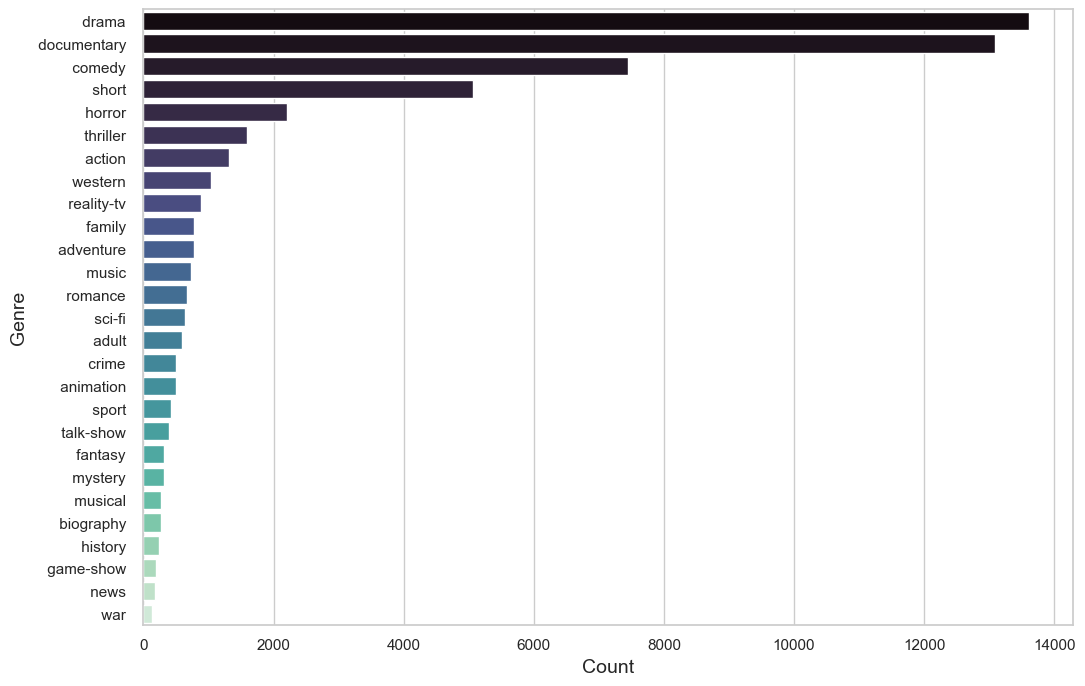

In [33]:
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

# Assuming train_data is already loaded and contains the GENRE column
counts = train_data.GENRE.value_counts().reset_index()
counts.columns = ['GENRE', 'Count']

plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

# Create the barplot with a color palette
sns.barplot(x='Count', y='GENRE', data=counts, palette='mako', hue='GENRE', dodge=False, legend=False)

# Add labels and title
plt.xlabel('Count', fontsize=14)
plt.ylabel('Genre', fontsize=14)
plt.show()

<h5>Lets find the lenght of the Description</h5>

In [10]:
train_data['LENGTH']=train_data['DESCRIPTION'].apply(len)
train_data.head()

,ID,TITLE,GENRE,DESCRIPTION,LENGTH
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625


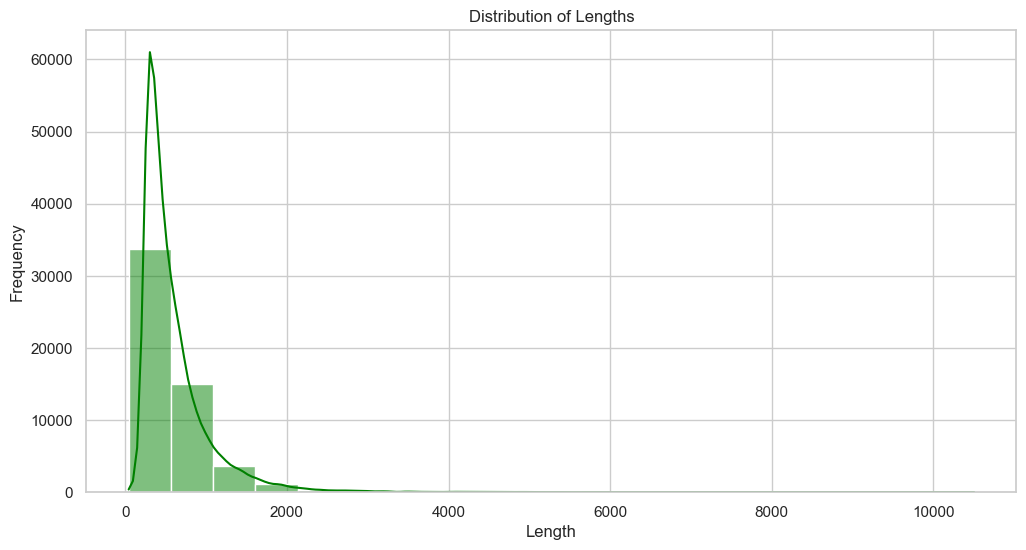

In [35]:
plt.figure(figsize=(12, 6))

sns.histplot(data=train_data, x='LENGTH', bins=20, kde=True, color='green')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Distribution of Lengths')

plt.show()

### Text Cleaning and Preprocessing

In [11]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer

# Ensure nltk resources are downloaded
# nltk.download('stopwords')
# nltk.download('punkt')

# Initialize stemmer and stopwords
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()  # Lowercase all characters
    text = re.sub(r'-', ' ', text)  # Replace hyphens with spaces
    text = re.sub(r'\d+', ' ', text)  # Remove digits
    text = re.sub(r'@\S+', '', text)  # Remove Twitter handles
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'pic.\S+', '', text)  # Remove image links
    text = re.sub(r"[^a-zA-Z\s']", ' ', text)  # Keep only letters and spaces

    words = nltk.tokenize.word_tokenize(text)
    words = [stemmer.stem(word) for word in words if word not in stop_words and len(word) > 2]
    text = ' '.join(words)
    
    # Remove leading/trailing spaces and repeated spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Test the cleaning function with various input texts
sample_texts = [
    "Check out my blog at https://example.com and follow me @exampleuser!",
    "Python is AWESOME! Learn it in 2024. Visit www.learnpython.org for more info.",
    "It's a state-of-the-art technology that's changing the world.",
    "  The quick brown fox   jumps over the lazy dog. The fox is quick.  ",
    "Hello!!! How are you??? #amazing @world",
    "123 Main St. - New York, NY 10001! Contact: info@example.com or call (123) 456-7890.",
    "Good morning 😊! Ready to start the day with a smile 😃?"
]

for text in sample_texts:
    print(f'Original text: {text}')
    print(f'Cleaned text: {clean_text(text)}')
    print('---')


Original text: Check out my blog at https://example.com and follow me @exampleuser!
Cleaned text: check blog follow
---
Original text: Python is AWESOME! Learn it in 2024. Visit www.learnpython.org for more info.
Cleaned text: python awesom learn visit www learnpython org info
---
Original text: It's a state-of-the-art technology that's changing the world.
Cleaned text: stat art technolog chang world
---
Original text:   The quick brown fox   jumps over the lazy dog. The fox is quick.  
Cleaned text: quick brown fox jump lazy dog fox quick
---
Original text: Hello!!! How are you??? #amazing @world
Cleaned text: hello amaz
---
Original text: 123 Main St. - New York, NY 10001! Contact: info@example.com or call (123) 456-7890.
Cleaned text: main new york contact info cal
---
Original text: Good morning 😊! Ready to start the day with a smile 😃?
Cleaned text: good morn ready start day smil
---


In [12]:
train_data['TEXT_CLEANING'] = train_data.DESCRIPTION.apply(clean_text)
test_data['TEXT_CLEANING'] = test_data.DESCRIPTION.apply(clean_text)

train_data.head()

,ID,TITLE,GENRE,DESCRIPTION,LENGTH,TEXT_CLEANING
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546,list convers doct par year old osc learn nobod...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184,broth sist past incestu rel cur murd rel murd ...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650,bus empty stud field trip muse nat hist littl ...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082,help unemploy fath mak end meet edi twin sist ...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625,film titl ref recov body ground zero also stat...


In [13]:
train_data['LENGTH_TEXT_CLEANING']=train_data['TEXT_CLEANING'].apply(len)
train_data.head()

,ID,TITLE,GENRE,DESCRIPTION,LENGTH,TEXT_CLEANING,LENGTH_TEXT_CLEANING
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546,list convers doct par year old osc learn nobod...,306
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184,broth sist past incestu rel cur murd rel murd ...,74
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650,bus empty stud field trip muse nat hist littl ...,315
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082,help unemploy fath mak end meet edi twin sist ...,606
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625,film titl ref recov body ground zero also stat...,293


### Histograms for text length before and after cleaning

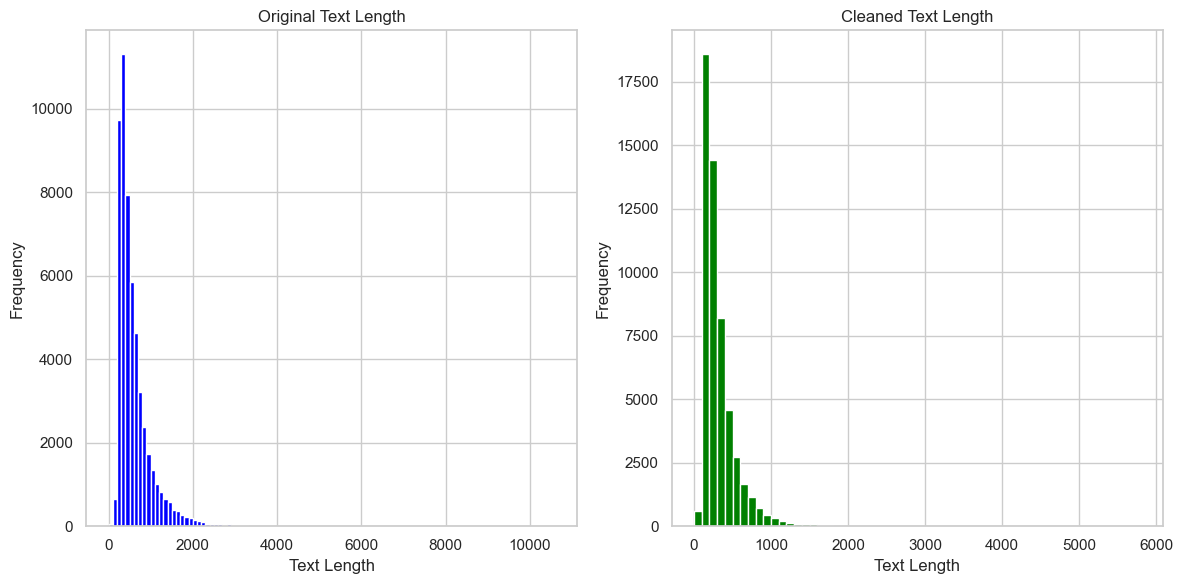

In [39]:
plt.figure(figsize=(12, 6))

# Original text length distribution
plt.subplot(1, 2, 1)
original_lengths = train_data['DESCRIPTION'].apply(len)
plt.hist(original_lengths, bins=range(0, max(original_lengths) + 100, 100), color='blue')
plt.title('Original Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

# Cleaned text length distribution
plt.subplot(1, 2, 2)
cleaned_lengths = train_data['TEXT_CLEANING'].apply(len)
plt.hist(cleaned_lengths, bins=range(0, max(cleaned_lengths) + 100, 100), color='green')
plt.title('Cleaned Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [14]:
#Remove extremely long descriptions: outliers
print('Dataframe size (before removal): ',len(train_data))
filt=train_data['LENGTH_TEXT_CLEANING']>2000
train_data.drop(train_data[filt].index,axis=0,inplace=True)     # filter rows having cleaned description length > 2000
print('Dataframe size (after removal): ',len(train_data))
print(f'Removed rows: {filt.sum()}')

Dataframe size (before removal):  54214
Dataframe size (after removal):  54139
Removed rows: 75


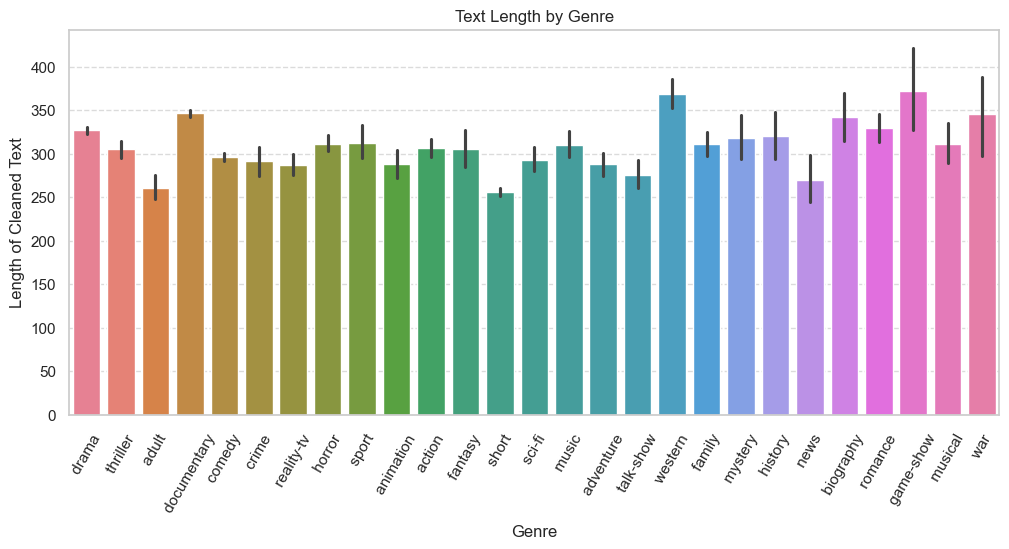

In [41]:
plt.figure(figsize=(12, 5))
sns.set_theme(style="whitegrid")

# Create the bar plot
sns.barplot(x='GENRE', y='LENGTH_TEXT_CLEANING', data=train_data, palette='husl',hue='GENRE')

# Add labels and title
plt.xlabel('Genre')
plt.ylabel('Length of Cleaned Text')
plt.title('Text Length by Genre')

# Rotate x-tick labels for better readability
plt.xticks(rotation=60)

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)


# Show the plot
plt.show()

In [15]:
num_words = 50000
max_len = 250
tokenizer = Tokenizer(num_words=num_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train_data['TEXT_CLEANING'].values)

In [16]:
test_path= "datasets/movie genre/test_data_solution.csv"
test_data_solution=pd.read_csv(test_path)
test_data_solution.head()

,ID,TITLE,GENRE,DESCRIPTION
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a mart...


In [17]:
X = tokenizer.texts_to_sequences(train_data['TEXT_CLEANING'].values)
X = pad_sequences(X, maxlen=max_len)
y = pd.get_dummies(train_data['GENRE']).values

X_test = tokenizer.texts_to_sequences(test_data['TEXT_CLEANING'].values)
X_test = pad_sequences(X_test, maxlen=max_len)
y_test = pd.get_dummies(test_data_solution['GENRE']).values

### Build the model

In [45]:
EMBEDDING_DIM = 100
model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.1, recurrent_dropout=0.2))
model.add(Dense(27, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              mode='auto')]
history = model.fit(X, y, epochs=10, batch_size=32,validation_data=(X_test,y_test), callbacks=my_callbacks)

Epoch 1/10
1692/1692 [==============================] - 1001s 589ms/step - loss: 1.9544 - accuracy: 0.4347 - val_loss: 1.6772 - val_accuracy: 0.5117
Epoch 2/10
1692/1692 [==============================] - 907s 536ms/step - loss: 1.4745 - accuracy: 0.5724 - val_loss: 1.5296 - val_accuracy: 0.5547
Epoch 3/10
1692/1692 [==============================] - 891s 527ms/step - loss: 1.1939 - accuracy: 0.6551 - val_loss: 1.4987 - val_accuracy: 0.5616
Epoch 4/10
1692/1692 [==============================] - 1005s 594ms/step - loss: 0.9635 - accuracy: 0.7189 - val_loss: 1.5776 - val_accuracy: 0.5539
Epoch 5/10
1692/1692 [==============================] - 1129s 667ms/step - loss: 0.7708 - accuracy: 0.7756 - val_loss: 1.7375 - val_accuracy: 0.5348


In [47]:
model.save('Movie Genre Classification.h5')

C:\Users\RONIT KUMAR\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


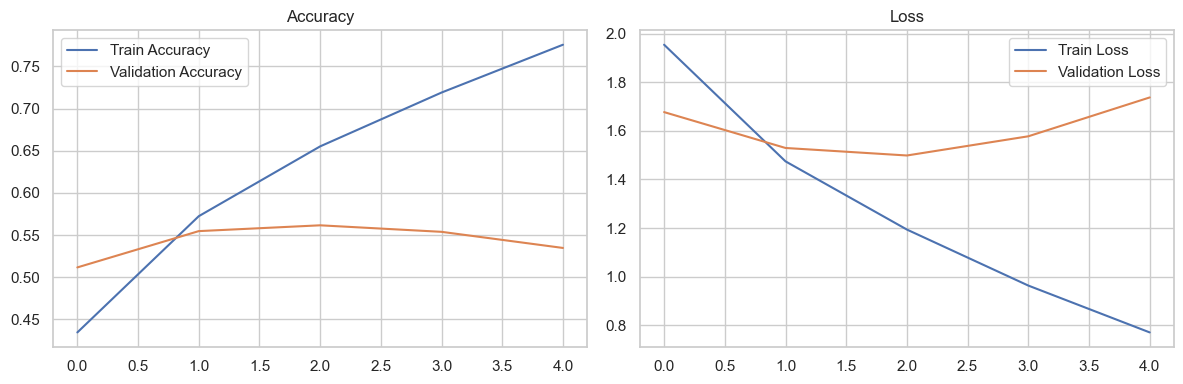

In [48]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.tight_layout()
plt.show()

In [18]:
# Load your trained model
model = load_model('Movie Genre Classification.h5')
GENRElabel = LabelEncoder()

sequences = tokenizer.texts_to_sequences(test_data['TEXT_CLEANING'].values)
X_test = pad_sequences(sequences, maxlen=max_len)

# Make predictions
y_pred = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Encode true labels if needed (ensure they match the format expected by your model)
y_true = GENRElabel.fit_transform(test_data_solution['GENRE'])

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy * 100:.2f}%")


1694/1694 [==============================] - 100s 59ms/step
Accuracy: 54.48%


In [19]:
# Assuming tokenizer and max_len are defined as in your training code
Descriptions = [
    "Listening in to a conversation between his doctor and parents, 10-year-old Oscar learns what nobody has the courage to tell him. He only has a few weeks to live. Furious, he refuses to speak to anyone except straight-talking Rose, the lady in pink he meets on the hospital stairs. As Christmas approaches, Rose uses her fantastical experiences as a professional wrestler, her imagination, wit and charm to allow Oscar to live life and love to the full, in the company of his friends Pop Corn, Einstein, Bacon and childhood sweetheart Peggy Blue.",
    "In tough economic times Max and Joey have all but run out of ideas until, they discover that senior housing is cheap. Not only that but Max's aunt just kicked the bucket and no one knows yet. In a hilarious series that always keeps you on your toes, the two friends take us on a cross-dressing, desperate and endearing ride through being broke."
]

# Tokenize and pad sequences
sequences = tokenizer.texts_to_sequences(Descriptions)
X_pred = pad_sequences(sequences, maxlen=max_len)

# Make predictions
y_pred = model.predict(X_pred)

# Convert predicted probabilities to class labels
predicted_classes = np.argmax(y_pred, axis=1)

# Display predictions
for description, predicted_class in zip(Descriptions, predicted_classes):
    print(f"Description: {description[:50]}...")  # Display first 50 characters of description
    print(f"Predicted Genre: {GENRElabel.inverse_transform([predicted_class])[0]}")  # Inverse transform to get genre
    print()

1/1 [==============================] - 0s 47ms/step
Description: Listening in to a conversation between his doctor ...
Predicted Genre:  documentary 

Description: In tough economic times Max and Joey have all but ...
Predicted Genre:  short 



### Movie Genre Classification Predictor

In [ ]:
# Load your trained model and other necessary components
model = load_model('Movie Genre Classification.h5')  # Replace with your model path

# Define a function to be called when the button is clicked
def on_button_click(b):
    text_value = text_box.value
    
    # Tokenize and pad the input text
    sequences = tokenizer.texts_to_sequences([text_value])
    X_pred = pad_sequences(sequences, maxlen=max_len)
    
    # Predict using the model
    y_pred = model.predict(X_pred)
    
    # Convert predicted probabilities to class labels
    predicted_class_index = np.argmax(y_pred)
    predicted_genre = GENRElabel.inverse_transform([predicted_class_index])[0]
    
    # Print the predicted genre
    print(f"Film's GENRE is: {predicted_genre}")

# Create button and text box widgets
button = widgets.Button(description="PREDICT")
text_box = widgets.Text(placeholder="Enter film description")
text_box.layout.width = '500px'
text_box.layout.height = '30px'

# Attach the function to the button click event
button.on_click(on_button_click)

# Display the widgets
display(text_box)
display(button)